<center><h1>Multi-class compound structural classification using sklearn</center></h1>

## About our dataset for today

The objective of this exercise is to predict the structural category of a compound using some properties derived from the monoisotopic mass and the molecular formula of the compound. ~40,000 plant lipids were classified in the following eight categories, out of which ~8000 lipids have been randomly chosen for this exercise.

<img src="Lipids.jpg" height="700" width="700">

We first used Weka for classification. Although Weka also has a command line interface and is quite easy to use, its functionality, especially for multiclass classification, is limited. SkLearn has a lot more functionality than Weka, is much more powerful in its libraries, options and execution, and is more actively developed.

The overall pipeline for analysis of the lipid dataset is as follows:

* We will first perform some exploratory analysis of the data to understand the distribution of the various features. This dataset has been filtered properly already, so there's not much to edit post exploratory analysis.

* We will divide the dataset into training and test data, and set up machine learning runs with 10X cross-validation. We will build a model with a Random Forest classifier using training data and use it to predict the class of the test dataset examples

* Then, we will estimate the accuracy of the classifier using various metrics.

* Finally, we will determine which features were important for classification purposes

If at any point you wish to determine the effect of changing some parameters on the output, or want to print some internal variables, feel free to edit the code cell and re-run the cell.

## Exploratory analysis of the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import seaborn as sns

#Read in the file
s = pd.read_csv('small_input_file.tab',sep="\t")
s.head()

#How many columns does it have? 

,#LMID,Name,Category,Subcategory,Formula,Mass,NumofC,NumofH,NumofO,NumofN,...,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD
0,LMFA01090153,"(2E,4Z)-3-chlorohexa-2,4-dienedioic_acid",Fatty_Acyls,Fatty_Acids_and_Conjugates,C6H5O4N0S0P0,141.018786,6,5,4,0,...,0,0.833333,1.250000,1.500000,0.0,0.0,0.0,0.9876,0.0124,70
1,LMFA01020226,"19-methyl-5Z,9Z-eicosadienoic_acid",Fatty_Acyls,Fatty_Acids_and_Conjugates,C21H38O2N0S0P0,322.287181,21,38,2,0,...,0,1.809524,19.000000,10.500000,0.0,0.0,0.0,0.2872,0.2872,891
2,LMFA01050382,2R-methyl-3-hydroxy-propanoic_acid,Fatty_Acyls,Fatty_Acids_and_Conjugates,C4H8O3N0S0P0,104.047345,4,8,3,0,...,0,2.000000,2.666667,1.333333,0.0,0.0,0.0,0.0473,0.0473,455
3,LMFA01050018,5-hydroxy-heptanoic_acid,Fatty_Acyls,Fatty_Acids_and_Conjugates,C7H14O3N0S0P0,146.094295,7,14,3,0,...,0,2.000000,4.666667,2.333333,0.0,0.0,0.0,0.0943,0.0943,645
4,LMFA01160015,"(2R)-2-[(1R)-1-hydroxy-19-{(1R,2R)-2-[(2R,19S,...",Fatty_Acyls,Fatty_Acids_and_Conjugates,C88H174O4N0S0P0,1295.341213,88,174,4,0,...,0,1.977273,43.500000,22.000000,0.0,0.0,0.0,0.3412,0.3412,263


In [4]:
#Get some basic numerical descriptors of the various columns
#Uncomment each of these lines one at a time
# print (s.info())
print (s.describe())

#REMEMBER: Categorical features CANNOT be used for machine learning unless you transform them somehow 
# into numerical features. 

#Questions:
#1) What are categorical features?
#2) Which features in this dataset can be used for machine learning?

              Mass       NumofC       NumofH       NumofO       NumofN  \
count  8040.000000  8040.000000  8040.000000  8040.000000  8040.000000   
mean    795.993384    44.530846    76.742537    10.400373     0.518408   
std     529.267887    28.203330    54.208235    10.691237     1.257854   
min      57.997277     2.000000     2.000000     0.000000     0.000000   
25%     406.453851    23.000000    32.000000     5.000000     0.000000   
50%     735.494473    40.000000    73.000000     7.000000     0.000000   
75%     916.751992    58.000000   100.000000    13.000000     0.000000   
max    3173.437217   145.000000   270.000000    78.000000     8.000000   

            NumofP       NumofS          H:C          H:O          C:O  \
count  8040.000000  8040.000000  8040.000000  8040.000000  8040.000000   
mean      0.317786     0.024876     1.652344    10.503900     6.141556   
std       0.591125     0.177411     0.332308     8.318223     4.662032   
min       0.000000     0.000000     0

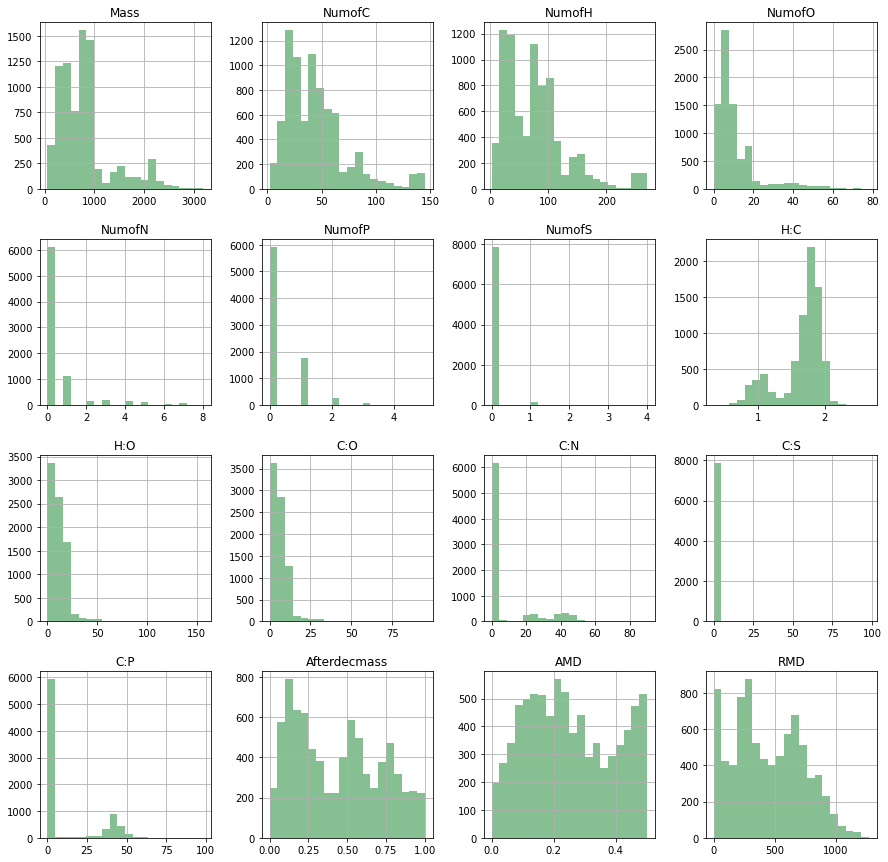

In [9]:
#Plotting the distributions of the various features
s.hist(bins=20,figsize=(15,15), color='#86bf91');

#What is matplotlib plotting here? How does it know what values to make histograms from?

__Exercise 1:__ 

Notice the ; at the end of the above command. Remove it and rerun code. What happens?

In [6]:
#Next we look at correlations between the different variables. 
allcorrel=s.corr()
allcorrel.columns
#len(allcorrel.columns)
allcorrel

#Why do you need to do this analysis? What will happen if correlated variables are included for training 
#the machine learning models?

,Mass,NumofC,NumofH,NumofO,NumofN,NumofP,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD
Mass,1.000000,0.961906,0.941778,0.819958,0.536618,0.149777,-0.019340,0.287180,-0.059477,-0.105774,0.263280,0.017273,0.108919,0.392486,-0.190673,-0.682131
NumofC,0.961906,1.000000,0.988105,0.638859,0.354107,0.092675,-0.080976,0.337453,0.096838,0.050010,0.181401,-0.043429,0.077555,0.523915,-0.177166,-0.653206
NumofH,0.941778,0.988105,1.000000,0.592213,0.348003,0.137449,-0.083642,0.462542,0.141324,0.075763,0.217010,-0.042224,0.130964,0.560491,-0.122242,-0.580713
NumofO,0.819958,0.638859,0.592213,1.000000,0.708235,0.095030,0.037181,0.027131,-0.376191,-0.398118,0.306878,0.053665,0.054290,0.000430,-0.228993,-0.596910
NumofN,0.536618,0.354107,0.348003,0.708235,1.000000,0.256545,0.306762,0.166060,-0.233511,-0.260604,0.474072,0.384644,0.022794,-0.048333,-0.035039,-0.281621
NumofP,0.149777,0.092675,0.137449,0.095030,0.256545,1.000000,0.235382,0.295533,-0.158070,-0.204811,0.296271,0.318955,0.808305,0.044792,0.317309,-0.040109
NumofS,-0.019340,-0.080976,-0.083642,0.037181,0.306762,0.235382,1.000000,-0.074099,-0.107746,-0.106768,-0.025029,0.768493,-0.039327,-0.052361,-0.049145,-0.081300
H:C,0.287180,0.337453,0.462542,0.027131,0.166060,0.295533,-0.074099,1.000000,0.365933,0.229781,0.292182,-0.015364,0.339068,0.472367,0.386169,0.251063
H:O,-0.059477,0.096838,0.141324,-0.376191,-0.233511,-0.158070,-0.107746,0.365933,1.000000,0.983299,-0.120117,-0.095386,-0.133213,0.350648,0.190391,0.254955
C:O,-0.105774,0.050010,0.075763,-0.398118,-0.260604,-0.204811,-0.106768,0.229781,0.983299,1.000000,-0.167863,-0.097351,-0.186255,0.291215,0.151964,0.239552


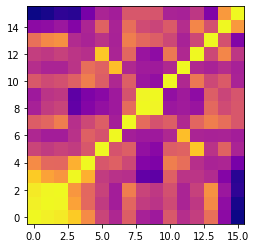

In [7]:
#Let us first plot a basic heatmap

fig, ax = plt.subplots()
ax.imshow(allcorrel,cmap='plasma',origin='lower')
plt.show()

As you can see, this does not make good X-axis and Y-axis labels. We need to provide them separately.

In [10]:
#For the next command, it is important to first understand what allcorrel.columns is
print (">", allcorrel.columns) #these are the column names
print (">>>", len(allcorrel.columns)) #the len function shows how many columns there are
print (">>>>>", np.arange(len(allcorrel.columns))) #arange functions returns all values from 0-16

#We will use these values for plotting a better heatmap

> Index(['Mass', 'NumofC', 'NumofH', 'NumofO', 'NumofN', 'NumofP', 'NumofS',
       'H:C', 'H:O', 'C:O', 'C:N', 'C:S', 'C:P', 'Afterdecmass', 'AMD', 'RMD'],
      dtype='object')
>>> 16
>>>>> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


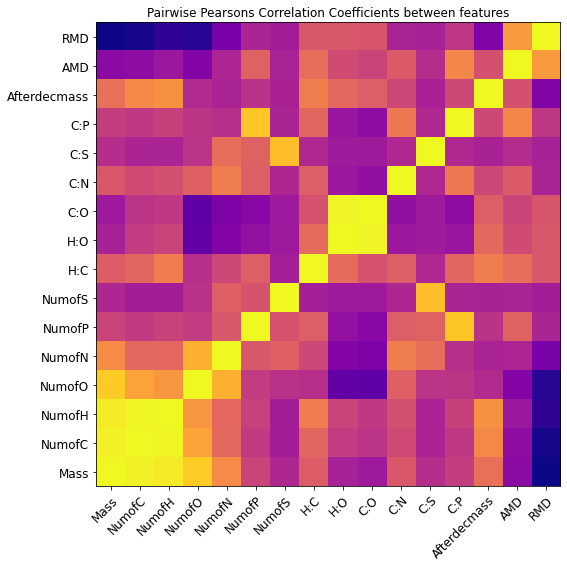

In [11]:
#Create empty plot variables
fig, ax = plt.subplots()

#Lets first set the ax
ax.imshow(allcorrel,cmap='plasma',origin='lower') #other color options: viridis, inferno, hot, magma, cividis etc
#https://matplotlib.org/tutorials/colors/colormaps.html

ax.set_xticks(np.arange(len(allcorrel.columns))) #This is the >>>>> above
ax.set_yticks(np.arange(len(allcorrel.columns))) #This is the >>>>> above
ax.set_xticklabels(allcorrel.columns) #X-axis labels > above
ax.set_yticklabels(allcorrel.columns) #Y-axis labels > above
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor",size=12)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",size=12)
ax.set_title("Pairwise Pearsons Correlation Coefficients between features")

#Now set the fig
fig.set_size_inches(8,8)
fig.tight_layout()

Seaborn, which is a wrapper built around matplotlib libraries, solves this problem of code complexity by making the whole block above basically a 4-line code block.

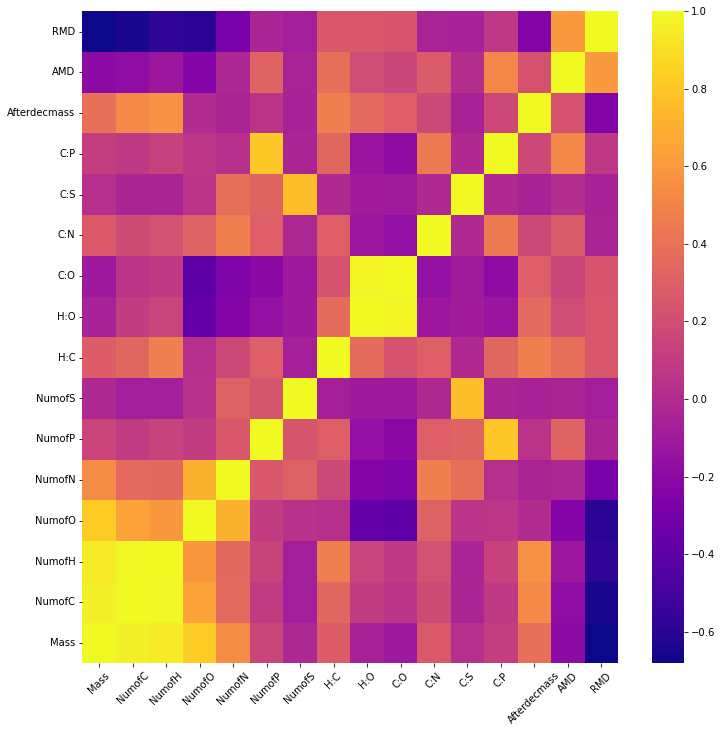

In [12]:
#Seaborn code
plt.figure(figsize=(12,12))
ax = sns.heatmap(allcorrel, cmap="plasma")
plt.xticks(rotation=45)
ax.invert_yaxis()

__POP QUIZ:__ 

1. What does the above figure show?
2. Which features are correlated with each other? From your organic chemistry knowledge, does it make sense?

## Setting up and executing the machine learning models

In [14]:
#import required modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
#Example Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [15]:
#First, define which columns are labels and which are features
labels=s['Category']
feats=s[s.columns[5:]] #Are these the correct columns? Go back to the table where you defined s and check.
annot=s[s.columns[0:5]]

#Additionally, uncomment each line below to print only the top 5 rows of each variable to make sure correct columns 
#were indeed pulled out
print (feats.head())
print (labels.head())

          Mass  NumofC  NumofH  NumofO  NumofN  NumofP  NumofS       H:C  \
0   141.018786       6       5       4       0       0       0  0.833333   
1   322.287181      21      38       2       0       0       0  1.809524   
2   104.047345       4       8       3       0       0       0  2.000000   
3   146.094295       7      14       3       0       0       0  2.000000   
4  1295.341213      88     174       4       0       0       0  1.977273   

         H:O        C:O  C:N  C:S  C:P  Afterdecmass     AMD  RMD  
0   1.250000   1.500000  0.0  0.0  0.0        0.9876  0.0124   70  
1  19.000000  10.500000  0.0  0.0  0.0        0.2872  0.2872  891  
2   2.666667   1.333333  0.0  0.0  0.0        0.0473  0.0473  455  
3   4.666667   2.333333  0.0  0.0  0.0        0.0943  0.0943  645  
4  43.500000  22.000000  0.0  0.0  0.0        0.3412  0.3412  263  
0    Fatty_Acyls
1    Fatty_Acyls
2    Fatty_Acyls
3    Fatty_Acyls
4    Fatty_Acyls
Name: Category, dtype: object


### Variation 1: Splitting data using train-test-split

Split your data into training and test sets - here we are specifying the size of the test set as 0.2 (20%) of the main dataset, which has 8040 entries. We have to specify training and test labels as well as features. Check if the split is really 80:20.

Also note that we are not doing any Kfold cross-validation. If the dataset is sufficiently large, you can train the model on the training and test it on a sufficiently large test set. This is not advisable, but is the simplest form of training that can be done. No cross-validation required.

In [16]:
train_feats, test_feats, train_labels, test_labels  = train_test_split (feats, labels, test_size=0.2)
print (test_labels.shape)
print (train_labels.shape)
print (test_feats.shape)
print (train_feats.shape)

#Does this look ok? Is the test set 20% of the original?

(1608,)
(6432,)
(1608, 16)
(6432, 16)


In [17]:
#Lets make a function here to train our machine learning model
#We are running a multi-class classifier here, instead of a binary classifier (yes, no)
def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features: features
    :param target: labels
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier(n_estimators=100)
    #estimators stands for the number of decision trees you want to implement
    #Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    clf.fit(features, target)
    return clf

In [18]:
#Running the randomForestClassifier
trained_model = random_forest_classifier(train_feats, train_labels)

In [19]:
#Let's see if the trained model predicts the test features correctly. 
pred_labels=trained_model.predict(test_feats)
pred_probs=trained_model.predict_proba(test_feats)

In [39]:
#Uncomment each line below to understand what's going on

trained_model.__dict__ #This just shows you the model, and in this case we are only using default values, so its showing up as ().
pred_labels
# pred_probs #Probabilities of each test instance belonging to each class  -- each row shows probability of 
# the instance belonging to each of the 8 classes

array(['Glycerophospholipids', 'Fatty_Acyls', 'Fatty_Acyls', ...,
       'Fatty_Acyls', 'Fatty_Acyls', 'Glycerophospholipids'], dtype=object)

In [47]:
trained_model.feature_names_in_
trained_model.feature_importances_

AttributeError: 'GridSearchCV' object has no attribute 'feature_names_in_'

### Variation 2: Using KFold cross-validation

In [35]:
from sklearn.model_selection import KFold
kfold = KFold(5, True, 1) #An empty splitter object for 5-fold cross validation

#Setup the basic model
rf = RandomForestClassifier(n_estimators=100)

#Train the model using cross-validation
scores = cross_val_score(rf, train_feats, train_labels, scoring='accuracy', cv=kfold, n_jobs=-1, verbose=3)

/Users/zl725/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] .................................... , score=0.970, total=   0.6s
[CV] .................................... , score=0.956, total=   0.6s
[CV] .................................... , score=0.962, total=   0.6s
[CV] .................................... , score=0.951, total=   0.6s
[CV] .................................... , score=0.964, total=   0.7s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


In [36]:
scores

array([0.96192696, 0.95648796, 0.95101089, 0.96423017, 0.96967341])

__POP QUIZ:__

* Which value does the score represent?
* Look at the manual entry and figure out how you can show AUROC values (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

### Variation 3: Using grid search across all RandomForest parameters

In [46]:
from sklearn.model_selection import GridSearchCV
#Set up the parameters for grid search
grid_param = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
#Create an empty model
rf = RandomForestClassifier(n_estimators=100)
kfold = KFold(5, True, 1)

#Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=grid_param, scoring='accuracy', cv=kfold, n_jobs=-1)

#Fit the model to the data
trained_model=grid_search.fit(train_feats, train_labels)

#See all properties of trained_model
print (trained_model.__dict__)

#Print best parameters
best_params = grid_search.best_params_
print (">>>>>", best_params)

/Users/zl725/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'scoring': 'accuracy', 'estimator': RandomForestClassifier(), 'n_jobs': -1, 'iid': 'deprecated', 'refit': True, 'cv': KFold(n_splits=5, random_state=1, shuffle=True), 'verbose': 0, 'pre_dispatch': '2*n_jobs', 'error_score': nan, 'return_train_score': False, 'param_grid': {'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}, 'multimetric_': False, 'best_index_': 3, 'best_score_': 0.9619091984566323, 'best_params_': {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}, 'best_estimator_': RandomForestClassifier(criterion='entropy'), 'refit_time_': 0.6443920135498047, 'scorer_': make_scorer(accuracy_score), 'cv_results_': {'mean_fit_time': array([0.76813345, 1.59609385, 2.34210873, 0.92047997, 1.96146193,
       2.82620316, 0.97334986, 1.9733562 , 3.08845477, 1.29480343,
       2.47020793, 2.90366178]), 'std_fit_time': array([0.02194384, 0.05470089, 0.05519406, 0.11073503, 0.11543402,
       0.12012866, 0.06566219, 0.12759846, 0.09243

OK - now we are proceeding with the best model from grid search and seeing how it behaves with the test dataset. We will:
* Make predictions on the test data
* Output the predictions to a tab-delimited file
* See if the file is correctly formatted
* Fix any errors that occur

In [48]:
# Performance on the test set
pred_labels=trained_model.predict(test_feats)
pred_probs=trained_model.predict_proba(test_feats)

Let us output these predictions to a file

In [49]:
#Now check how many elements are contained within pred_labels. Is it a matrix of values?
dfx = pd.concat([test_feats, pd.DataFrame(pred_labels, columns=["Predicted labels"]), 
                 pd.DataFrame(pred_probs, columns=["A","B","C","D","E","F","G","H"])], axis=1)
dfx.to_csv(path_or_buf="results.tab",index=True,sep='\t')

#Check the output. Is it correct? You should scroll down to t

In [50]:
#Now check how many elements are contained within pred_labels. Is it a matrix of values?

dfx1 = pd.concat([test_feats, pd.DataFrame(test_labels)], axis=1, sort=False)
dfx = pd.concat([dfx1.reset_index(),
                 pd.DataFrame(pred_labels, columns=["Predicted labels"]), 
                 pd.DataFrame(pred_probs, columns=["A","B","C","D","E","F","G","H"])], axis=1)

dfx.to_csv(path_or_buf="results2.tab",index=True,sep='\t')

In [51]:
#why did we have to use such a complicated statement? Because there are no indexes available for the pred_labels/probs
#to merge with the test_labels and test_feats datasets.

pred_probs
dfx1.head()

,Mass,NumofC,NumofH,NumofO,NumofN,NumofP,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD,Category
3580,772.504309,45,73,8,0,1,0,1.622222,9.125000,5.625000,0.0,0.0,45.0,0.5043,0.4957,642,Glycerophospholipids
43,112.088815,7,12,1,0,0,0,1.714286,12.000000,7.000000,0.0,0.0,0.0,0.0888,0.0888,792,Fatty_Acyls
1221,316.203846,20,28,3,0,0,0,1.400000,9.333333,6.666667,0.0,0.0,0.0,0.2038,0.2038,645,Fatty_Acyls
1125,252.208930,16,28,2,0,0,0,1.750000,14.000000,8.000000,0.0,0.0,0.0,0.2089,0.2089,828,Fatty_Acyls
4300,759.577808,42,82,8,1,1,0,1.952381,10.250000,5.250000,42.0,0.0,42.0,0.5778,0.4222,556,Glycerophospholipids


In [52]:
dfx1['pred_labels']=pred_labels
dfx1

,Mass,NumofC,NumofH,NumofO,NumofN,NumofP,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD,Category,pred_labels
3580,772.504309,45,73,8,0,1,0,1.622222,9.125000,5.625000,0.0,0.0,45.0,0.5043,0.4957,642,Glycerophospholipids,Glycerophospholipids
43,112.088815,7,12,1,0,0,0,1.714286,12.000000,7.000000,0.0,0.0,0.0,0.0888,0.0888,792,Fatty_Acyls,Fatty_Acyls
1221,316.203846,20,28,3,0,0,0,1.400000,9.333333,6.666667,0.0,0.0,0.0,0.2038,0.2038,645,Fatty_Acyls,Fatty_Acyls
1125,252.208930,16,28,2,0,0,0,1.750000,14.000000,8.000000,0.0,0.0,0.0,0.2089,0.2089,828,Fatty_Acyls,Fatty_Acyls
4300,759.577808,42,82,8,1,1,0,1.952381,10.250000,5.250000,42.0,0.0,42.0,0.5778,0.4222,556,Glycerophospholipids,Glycerophospholipids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,259.229999,18,29,0,1,0,0,1.611111,0.000000,0.000000,18.0,0.0,0.0,0.2300,0.2300,887,Fatty_Acyls,Fatty_Acyls
929,296.271531,19,36,2,0,0,0,1.894737,18.000000,9.500000,0.0,0.0,0.0,0.2715,0.2715,916,Fatty_Acyls,Fatty_Acyls
585,236.101705,9,20,1,2,0,2,2.222222,20.000000,9.000000,4.5,4.5,0.0,0.1017,0.1017,431,Fatty_Acyls,Fatty_Acyls
1811,646.626396,43,82,3,0,0,0,1.906977,27.333333,14.333333,0.0,0.0,0.0,0.6264,0.3736,578,Glycerolipids,Fatty_Acyls


The problem with sklearn is it is not straightforward to export out the predictions of the model, since the indexes of the predictions (pred_labels, pred_probs) are all messed up. Hence, a recommended strategy is -- after we are satisfied with a model -- we run it against the whole dataset and identify the test examples separately. That is what we will do.

## Checking the overall performance of the model

In this section, we will determine:
1. Accuracy of the model
2. Area Under the Receiver Operating Characteristic
3. Confusion matrix - how many instances are misclassified vs. correctly classified
4. Feature importance

In [53]:
#class_names=test_labels[unique_labels[test_labels, pred_labels]]
class_names=list(set(train_labels))
class_names

#This is the complete, unique list of labels in the training dataset

['Glycerolipids',
 'Fatty_Acyls',
 'Polyketides',
 'Glycerophospholipids',
 'Sterol_Lipids',
 'Saccharolipids',
 'Prenol_Lipids',
 'Sphingolipids']

In [54]:

len(pred_labels)

1608

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Using this model, predict labels of test features and see how well it behaves
for i in range(0, 20): #Change this number from 10 to something else (<20) and see what happens
        print ("Original label :: {} and Predicted label :: {}".format(list(test_labels)[i], pred_labels[i]))
print("Overall accuracy:",accuracy_score(test_labels, pred_labels))

#What do you think was printed here? 
#Uncheck the following command. Run the block again and check the output as well as the above command.
#Can you tell now?

print (">>>", len(list(test_labels)))

#Confusion matrix
class_names=list(set(train_labels))
cm=confusion_matrix(test_labels, pred_labels, labels=class_names)
print (cm)

Original label :: Glycerophospholipids and Predicted label :: Glycerophospholipids
Original label :: Fatty_Acyls and Predicted label :: Fatty_Acyls
Original label :: Fatty_Acyls and Predicted label :: Fatty_Acyls
Original label :: Fatty_Acyls and Predicted label :: Fatty_Acyls
Original label :: Glycerophospholipids and Predicted label :: Glycerophospholipids
Original label :: Glycerophospholipids and Predicted label :: Glycerophospholipids
Original label :: Glycerophospholipids and Predicted label :: Glycerophospholipids
Original label :: Glycerolipids and Predicted label :: Glycerolipids
Original label :: Glycerophospholipids and Predicted label :: Glycerophospholipids
Original label :: Sphingolipids and Predicted label :: Sphingolipids
Original label :: Glycerophospholipids and Predicted label :: Glycerophospholipids
Original label :: Glycerolipids and Predicted label :: Glycerolipids
Original label :: Sterol_Lipids and Predicted label :: Sterol_Lipids
Original label :: Polyketides a

In [56]:
#Normalized confusion matrix
#Here we are normalizing each of the value above by the total number of examples of each category in the test dataset
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]*100
cm

array([[ 99.30555556,   0.69444444,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  95.39007092,   0.35460993,   0.        ,
          1.06382979,   0.        ,   2.83687943,   0.35460993],
       [  0.        ,   0.69686411,  98.60627178,   0.34843206,
          0.        ,   0.        ,   0.34843206,   0.        ],
       [  0.        ,   0.        ,   0.        , 100.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   5.2173913 ,   2.60869565,   0.        ,
         88.69565217,   0.        ,   3.47826087,   0.        ],
       [  0.        ,   2.08333333,   0.        ,   0.        ,
          0.        ,  97.91666667,   0.        ,   0.        ],
       [  5.12820513,  15.38461538,   5.12820513,   5.12820513,
         10.25641026,   0.        ,  53.84615385,   5.12820513],
       [  0.        ,   0.63694268,   0.        ,   0.        ,
          0.        ,   0.       

In [57]:
import sklearn
sklearn.__version__

'0.23.2'

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Glycerolipids'),
  Text(1, 0, 'Fatty_Acyls'),
  Text(2, 0, 'Polyketides'),
  Text(3, 0, 'Glycerophospholipids'),
  Text(4, 0, 'Sterol_Lipids'),
  Text(5, 0, 'Saccharolipids'),
  Text(6, 0, 'Prenol_Lipids'),
  Text(7, 0, 'Sphingolipids')])

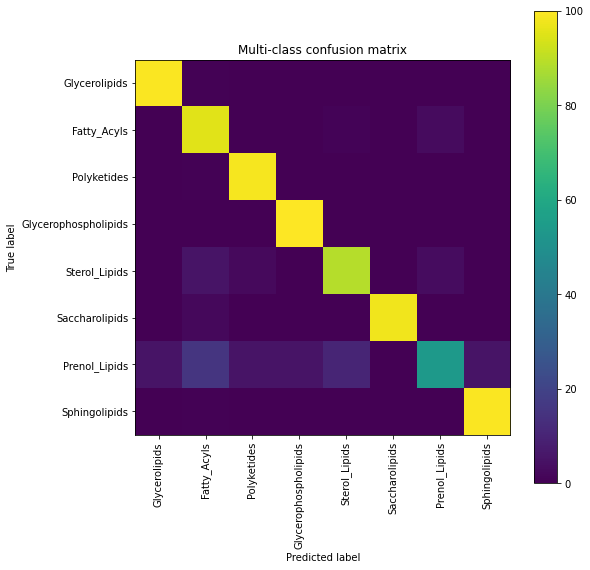

In [58]:
#Plotting the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap="viridis")
ax.figure.colorbar(im, ax=ax)
fig.set_size_inches(7,7)
fig.tight_layout()

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=class_names, yticklabels=class_names,
       title="Multi-class confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')
#ax.tick_params(direction=2)
plt.xticks(rotation=90)

### Exercise 1:

* What does the plot show?
* Which structural categories was the model able to classify properly, and where was it confused?
* Why do you think the model was confused by those categories? What is it confused with? Why? Refer to the category definitions shown above to address these questions.


## Plotting the Area Under the Receiver Operating Characteristic (AUROC) curve

AUROC curve is always in a binary context, while here we have run a multiclass classifier. 
Hence, it is important to format the AUROC calculations in a way that enables binary calculation/plotting. We will convert all labels into only two types -- Fatty Acyls and Not Fatty Acyls - and run the classifier again

In [59]:
#Plotting the Area Under the Receiver Operating Characteristic (AUROC) curve
from sklearn.metrics import roc_curve, auc

#Get the labels and features again, just so that we don't mess up the original variables
labels2=s['Category']
feats2=s[s.columns[5:]]
train_feats2, test_feats2, train_labels2, test_labels2  = train_test_split (feats2, labels2, test_size=0.2)

for name in class_names:
    #print (name)
    if name=='Fatty_Acyls':
        pass
    else:
        train_labels2=pd.Series(train_labels2).str.replace(name,'Not_FA') #replace labels in training
        test_labels2=pd.Series(test_labels2).str.replace(name,'Not_FA') #replace labels in test

#Run Random Forest classifier on them and print the overall model score
rf = RandomForestClassifier(n_estimators=100, oob_score=True) 
trained_model2 = rf.fit(train_feats2, train_labels2)
model_scores2=rf.score(test_feats2, test_labels2)
print ("Overall model score: ", model_scores2)

Overall model score:  0.9813432835820896


In [66]:
#Get the Area Under the Receiver Operating Characteristic (AUC-ROC or AUROC)
y_score=trained_model2.predict_proba(test_feats2)[:, 1]
# fpr, tpr, _ = roc_curve(test_labels2, y_score, pos_label='Fatty_Acyls')
fpr, tpr, _ = roc_curve(test_labels2, y_score, pos_label='Not_FA')
#Does the figure make sense? Can AUROC be lower than random expectation?

#Change pos_label to Not_FA and see how the AUROC figure changes below.

#This is a known issue with AUROC, occurring mostly in the context of multi-class classification. 
#Some wrapper packages get around this issue. Nonetheless, we can obtain correct AUROC plots by flipping the
#class that is being plotted i.e. Not_FA instead of Fatty_Acyls


roc_auc = auc(fpr, tpr)
print (roc_auc)

0.9962635906312544


In [67]:
type(y_score)

numpy.ndarray

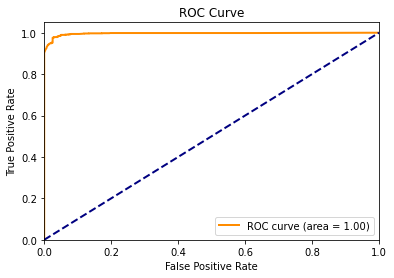

In [68]:
#Plot the AUROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Finding which features were important for binary classification of Fatty Acyls

Feature importance is calculated as a specific metric, which is different for different algorithms. See a detailed review here: https://machinelearningmastery.com/calculate-feature-importance-with-python/. In our case, rf.feature_importance_ method by default uses the Gini impurity decrease method, which calculates the drop in "impurity" of the predicted labels, if individual features were removed from the nodes of the RF decision trees.

There are some issues with this metric with certain types of datasets. Depending on your data structure, you may need to choose different feature importance measures.

In [69]:
train_feats2.columns

Index(['Mass', 'NumofC', 'NumofH', 'NumofO', 'NumofN', 'NumofP', 'NumofS',
       'H:C', 'H:O', 'C:O', 'C:N', 'C:S', 'C:P', 'Afterdecmass', 'AMD', 'RMD'],
      dtype='object')

              importance
Mass            0.179231
NumofO          0.143119
NumofC          0.127469
H:C             0.110268
RMD             0.106169
NumofH          0.057926
Afterdecmass    0.050285
C:O             0.049778
H:O             0.040129
AMD             0.035166
NumofP          0.027783
NumofN          0.025903
C:N             0.014969
C:S             0.012550
C:P             0.011189
NumofS          0.008066


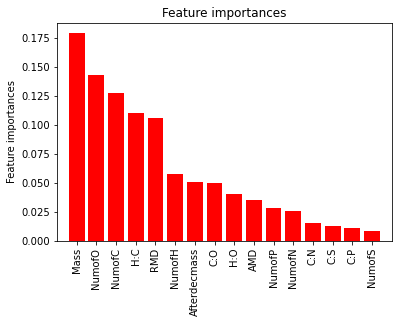

In [70]:
## Feature importance

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train_feats2.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print the feature ranking
print (feature_importances)

# Plot the feature importances of the forest
figcolumns=feature_importances.index.values
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_feats2.shape[1]), feature_importances.importance,
       color="r", align="center")
plt.ylabel("Feature importances")
plt.xticks(range(train_feats2.shape[1]), figcolumns, rotation='vertical')
plt.xlim([-1, train_feats2.shape[1]])
plt.show()

__Copy-paste the above plot into a Word File or a Powerpoint presentation__

__Exercise 2__:

* Do the feature importances make sense, based on what you know about Fatty Acyls?

## Writing the predictions to output

This is the final step in our analysis.

In [71]:
feats=s[s.columns[5:]]
full_labels=trained_model.predict(feats)
full_probs=trained_model.predict_proba(feats)
feats['Predictions']=full_labels
feats2=pd.concat([feats, annot, pd.DataFrame(pred_probs, columns=["A","B","C","D","E","F","G","H"])], axis=1)
feats2.to_csv(path_or_buf="results3.tab",index=True,sep='\t')

/var/folders/fj/vhnlwf151bb8nxy3tgvdmlm9t7f2pg/T/ipykernel_41053/1487664475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats['Predictions']=full_labels


## HOMEWORK - 10 points

Repeat the binary classification with Glycerophospholipids, and check which features are important. To clarify the question, you have already performed multi-class classification. You simply need to obtain AUROC and feature importances for Glycerophospholipids vs. Not_Glycerophospholipids. 

Make a single Jupyter Notebook with your name in the file name, and upload it on Canvas. Points will be given as follows:

1. How easy is it to run the code? -- 2 points
2. Is the code well-commented? -- 2 points
3. Is the AUROC graph correct? -- 2 points
4. Is the Feature Importance graph correct? -- 2 point
5. Is there an interpretation provided for feature importance -- 2 points

This exercise should take <15 minutes to complete and submit. Submit on Canvas by Wed morning 9am.

As you can see, the coding required for Python SciKit for running ML is fairly complicated, compared to the graphical interface of Weka. However, SciKit is very powerful, and once you get past the learning curve, you will be able to quickly run different algorithms using the HPC environment. SciKit also allows encoding neural networks as well as multi-label classification (not multi-class) -- where individual instances can be assigned to more than one labels -- which is not possible in Weka. 

The problem of complexity of sklearn is addressed by a different wrapper package called PyCaret that was released in Apr 2020. Everything you did above for sklearn can be accomplished by the following five lines of code. 

## Using PyCaret

In [72]:
s.head()

,#LMID,Name,Category,Subcategory,Formula,Mass,NumofC,NumofH,NumofO,NumofN,...,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD
0,LMFA01090153,"(2E,4Z)-3-chlorohexa-2,4-dienedioic_acid",Fatty_Acyls,Fatty_Acids_and_Conjugates,C6H5O4N0S0P0,141.018786,6,5,4,0,...,0,0.833333,1.250000,1.500000,0.0,0.0,0.0,0.9876,0.0124,70
1,LMFA01020226,"19-methyl-5Z,9Z-eicosadienoic_acid",Fatty_Acyls,Fatty_Acids_and_Conjugates,C21H38O2N0S0P0,322.287181,21,38,2,0,...,0,1.809524,19.000000,10.500000,0.0,0.0,0.0,0.2872,0.2872,891
2,LMFA01050382,2R-methyl-3-hydroxy-propanoic_acid,Fatty_Acyls,Fatty_Acids_and_Conjugates,C4H8O3N0S0P0,104.047345,4,8,3,0,...,0,2.000000,2.666667,1.333333,0.0,0.0,0.0,0.0473,0.0473,455
3,LMFA01050018,5-hydroxy-heptanoic_acid,Fatty_Acyls,Fatty_Acids_and_Conjugates,C7H14O3N0S0P0,146.094295,7,14,3,0,...,0,2.000000,4.666667,2.333333,0.0,0.0,0.0,0.0943,0.0943,645
4,LMFA01160015,"(2R)-2-[(1R)-1-hydroxy-19-{(1R,2R)-2-[(2R,19S,...",Fatty_Acyls,Fatty_Acids_and_Conjugates,C88H174O4N0S0P0,1295.341213,88,174,4,0,...,0,1.977273,43.500000,22.000000,0.0,0.0,0.0,0.3412,0.3412,263


In [1]:
import pycaret

In [2]:
from pycaret import classification
# numFeat = list(s.columns[5:])
# base = classification.setup(s, target='Category',ignore_features=['#LMID','Name','Subcategory','Formula'], 
#                             numeric_features=numFeat)

OSError: dlopen(/Users/zl725/.local/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/zl725/.local/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [ ]:
base_rf = classification.create_model('rf')

In [ ]:
tuned_rf = classification.tune_model(base_rf, n_iter=5, optimize = 'AUC')

In [ ]:
classification.evaluate_model(tuned_rf)


Look out for large datasets and relevant classification questions where ML can be applied! Let us know too, so that we can use those datasets in future classes!

In the next class, we will learn a bit about Deep Learning, and apply PyCaret for solving more machine learning problems. 

Happy coding!